# ARC Mistakes Classification

## About ARC

The Abstract Reasoning Challenge (ARC) is a benchmark dataset designed to test AI systems' ability to perform abstract reasoning tasks. ARC consists of visual puzzles where an AI must identify patterns and transformations between input-output grids.

Key characteristics of ARC:
- **Grid-based puzzles**: Each task involves colored grids (from 3x3 to 30x30). Every pixel can be colored in one of ten predefined colors.
- **Few-shot learning**: Only 2-5 training examples are provided per task
- **Diverse transformations**: There are many abstraction rules starting from rotation, mirroring, counting, grouping and etc to more complex.

Useful links:
- Main ARC site: https://arcprize.org/
- Kaggle competition: https://www.kaggle.com/c/arc-prize-2025/leaderboard
- All train and test tasks visualization: https://www.kaggle.com/code/allegich/arc-agi-2025-visualization-all-1000-120-tasks

## Quick Start

1. **Install dependencies**

```bash
pip install -r requirements.txt
```

2. **Run all cells** (Kernel → Restart & Run All).

3. Everything that matters is in the **last cell** – feel free to ignore the rest.

4. **Questions or errors?** DM us on Telegram chat.


In [1]:
import json

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

In [2]:
import sys
sys.path.append('../../src')
from data.arc import prepare_arc_tasks
from data.dataset import ARCDataset, AugmentDataset
from models.tokenizer import TaskTokenizer

In [3]:
metrics_path = {
    'rearc_lr3em4_bs64': {
        'val': None,
        'gen': {
            'greedy': {
                'train': 'data/generation_corrects_reloss_rearc_lr3em4_bs64_greedy_train.json',
                'val': 'data/generation_corrects_reloss_rearc_lr3em4_bs64_greedy_val.json',
            },
            'beam4': {
                'train': 'data/generation_corrects_reloss_rearc_lr3em4_bs64_beam4_train.json',
                'val': 'data/generation_corrects_reloss_rearc_lr3em4_bs64_beam4_val.json',
            },
        },
    },
}

In [4]:
def load_json_leaves(d):
    """
    Recursively traverse a nested dictionary and load JSON files at the leaf nodes.
    """
    if isinstance(d, dict):
        return {k: load_json_leaves(v) for k, v in d.items()}
    elif isinstance(d, str) and d.endswith('.json'):
        with open(d, 'r', encoding='utf-8') as f:
            return json.load(f)
    else:
        return d


metrics = load_json_leaves(metrics_path)

In [5]:
train_tasks, val_tasks, _ = prepare_arc_tasks('../../data/arc1')

tokenizer = TaskTokenizer(
    add_row_sep=True,
    segregate='row',
    target_only_test_output=True,
)

val_dataset_simple = ARCDataset(val_tasks)
val_dataset = AugmentDataset(val_dataset_simple, tokenizer, augment=False)

train_dataset_simple = ARCDataset(train_tasks)
train_dataset = AugmentDataset(train_dataset_simple, tokenizer, augment=False)

In [6]:
def is_seq_1d_valid_2d(seq_1d, tokenizer):
    if len(seq_1d) < 2:
        return None
    if seq_1d[-1] != tokenizer.sample_sep_token_id:
        return None
    if seq_1d[-2] != tokenizer.row_sep_token_id:
        return None
    if not np.isin(seq_1d, list(range(10)) + [tokenizer.sample_sep_token_id] + [tokenizer.row_sep_token_id]).all():
        return None

    row_sep_token_pos = np.sort(np.where(seq_1d == tokenizer.row_sep_token_id)[0])

    if len(row_sep_token_pos) <= 1:
        return seq_1d[:-1].reshape(1, -1)

    tobe_start = row_sep_token_pos[0]
    tobe_step = row_sep_token_pos[1] - row_sep_token_pos[0]
    tobe_pos_arange = np.arange(tobe_start, tobe_start + tobe_step * len(row_sep_token_pos), tobe_step)

    if not (tobe_start + 1 == tobe_step):
        return None
    if not (row_sep_token_pos == tobe_pos_arange).all():
        return None

    nrows = len(row_sep_token_pos)
    ncols = tobe_start

    tobe_error_inf = str(tobe_start) + '; ' + str(tobe_step) + '; ' + str(nrows) + '; ' + str(ncols) + '\n' + str(seq_1d.tolist())
    assert seq_1d.shape[0] == (nrows * (ncols + 1) + 1), tobe_error_inf

    return seq_1d[:-1].reshape(nrows, ncols + 1)

In [7]:
def plot_one(ax, matrix, key):
    cmap = colors.ListedColormap(['#000000', '#0074D9', '#FF4136', '#2ECC40', '#FFDC00',
                                  '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)
    input_matrix = matrix
    ax.imshow(input_matrix, cmap=cmap, norm=norm)
    ax.grid(True, which='both',color='lightgrey', linewidth=.5)

    plt.setp(plt.gcf().get_axes(), xticklabels=[], yticklabels=[])
    ax.set_xticks([x-0.5 for x in range(1 + len(input_matrix[0]))])
    ax.set_yticks([x-0.5 for x in range(1 + len(input_matrix))])
    ax.set_title(key)


def strike_cell(ax, x, y, color='red', lw=2):
    ax.plot([x, x + 1], [y, y + 1], color=color, linewidth=lw)
    ax.plot([x, x + 1], [y + 1, y], color=color, linewidth=lw)


def plot_generation_results(stats_greedy, stats_beam, true_board, tokenizer, suptitle):
    generated_board_1d_greedy = np.array(stats_greedy['generated_boards_1d'][0])
    generated_boards_1d_beam = [np.array(board) for board in stats_beam['generated_boards_1d']]

    task_key = stats_greedy['key']
    true_board_1d = np.array(stats_greedy['true_board_1d'])
    nrows, ncols = np.shape(true_board)
    true_board_2d = true_board_1d[:-1].reshape(nrows, ncols + 1)

    generated_valid = []

    generated_board_2d_greedy = is_seq_1d_valid_2d(generated_board_1d_greedy, tokenizer)
    if generated_board_2d_greedy is not None:
        generated_valid.append(('greedy', generated_board_2d_greedy))

    for i, one_generated_board_1d_beam in enumerate(generated_boards_1d_beam):
        generated_board_2d_beam = is_seq_1d_valid_2d(one_generated_board_1d_beam, tokenizer)
        if generated_board_2d_beam is not None:
            generated_valid.append(('beam %d' % i, generated_board_2d_beam))

    fig, axs = plt.subplots(1, len(generated_valid) + 1, squeeze=False, figsize=(4 * (len(generated_valid) + 1), 4))

    plot_one(axs[0, 0], true_board_2d[:, :-1].tolist(), key='true')

    for i, (key, board_2d) in enumerate(generated_valid):
        plot_one(axs[0, i + 1], board_2d[:, :-1].tolist(), key=key)
        if board_2d.shape == true_board_2d.shape:
            invalid_ids = np.nonzero(board_2d != true_board_2d)
            if len(invalid_ids) != 0:
                for x, y in zip(invalid_ids[0], invalid_ids[1]):
                    strike_cell(axs[0, i + 1], y - .5, x - .5, color='white', lw=1)

    fig.suptitle(suptitle, fontsize=14)
    fig.tight_layout()
    # fig.show()
    return fig

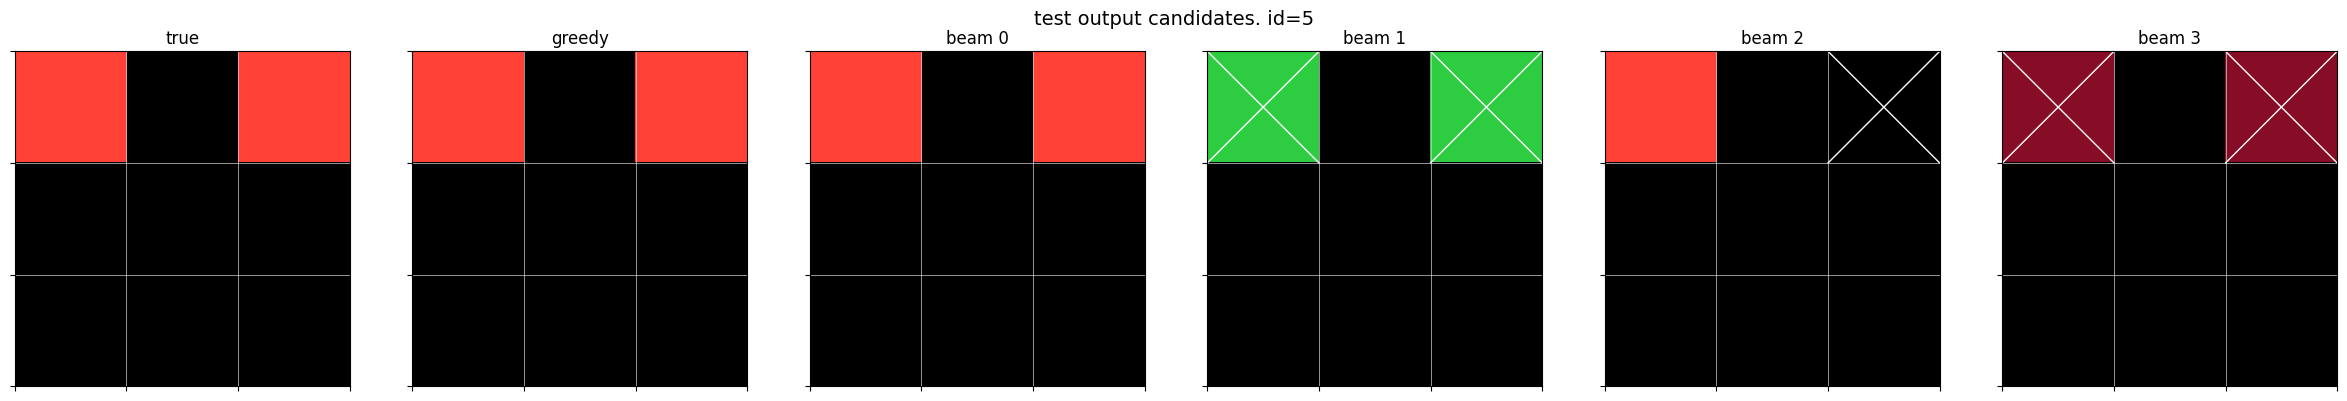

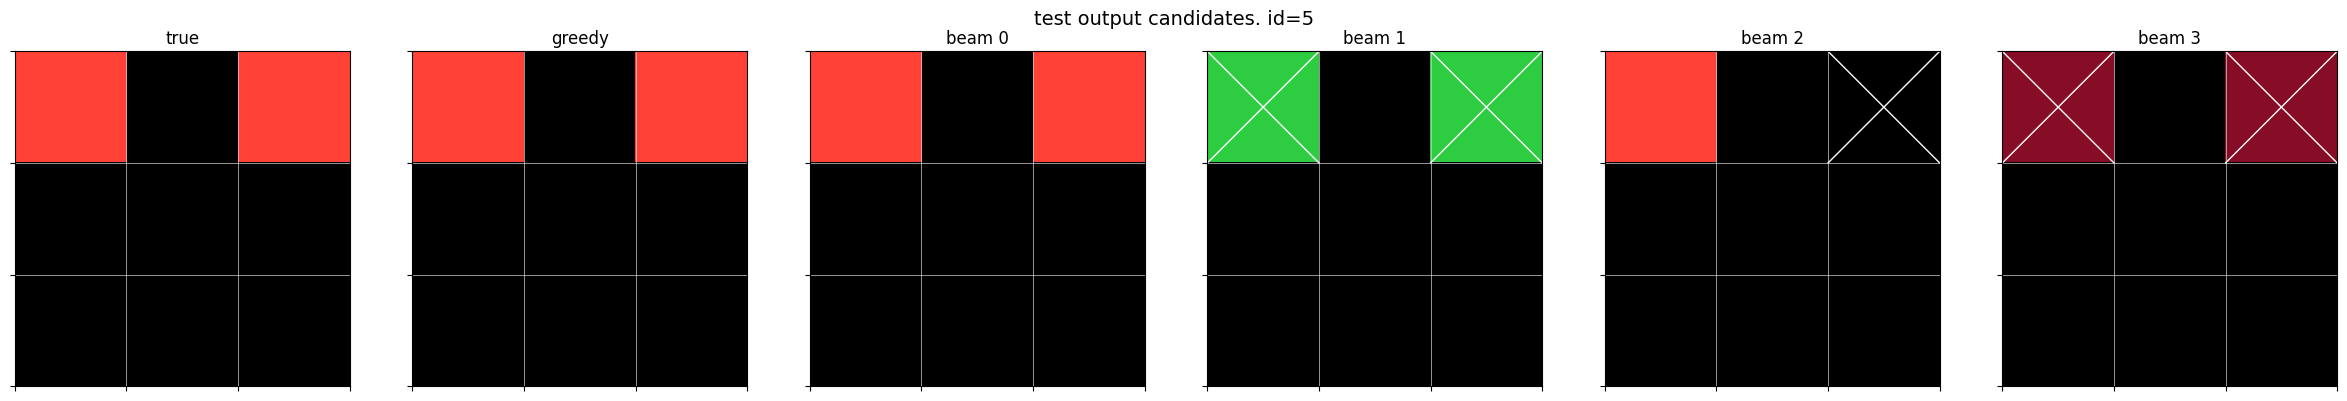

In [8]:
idx = 5
plot_generation_results(
    metrics['rearc_lr3em4_bs64']['gen']['greedy']['train'][idx],
    metrics['rearc_lr3em4_bs64']['gen']['beam4']['train'][idx],
    train_dataset[idx]['augmented_sample']['test'][0]['output'],
    tokenizer,
    suptitle='test output candidates. id=%d' % idx,
)

In [9]:
import matplotlib.pyplot as plt
from matplotlib import colors

# 0:black, 1:blue, 2:red, 3:green, 4:yellow, # 5:gray, 6:magenta, 7:orange, 8:sky, 9:brown

cmap = colors.ListedColormap(
    ['#000000', '#0074D9', '#FF4136', '#2ECC40', '#FFDC00',
     '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)


def plot_task(task, task_solutions, i, t):
    """ Plots the test and trains pairs of a specified task,
        using same color scheme as the ARC app. """    
    fs = 12    
    num_train = len(task['train'])
    num_test  = len(task['test'])
    
    w = num_train + num_test
    fig, axs  = plt.subplots(2, w, figsize=(2*w,2*2))
    plt.suptitle(f'Set #{i}, {t}:', fontsize=fs, fontweight='bold', y=1)
    
    for j in range(num_train):
        plot_one_2(axs[0, j], j, task, 'train', 'input')
        plot_one_2(axs[1, j], j, task, 'train', 'output')        
    
    for k in range(num_test):     
        plot_one_2(axs[0, j+k+1], k, task, 'test', 'input')
        # patch task with output
        task['test'][k]['output'] = task_solutions[k]
        plot_one_2(axs[1, j+k+1], k, task, 'test', 'output')

    # axs[1, j+1] = plt.figure(1).add_subplot(111)
    # axs[1, j+1].set_xlim([0, w])

    # axs[1, j+1].plot([num_train,num_train],[0,1],'-', linewidth=3, color = 'black')

    # axs[1, j+1].axis("off")

    fig.patch.set_linewidth(5)
    fig.patch.set_edgecolor('black') 
    fig.patch.set_facecolor('#dddddd')
   
    fig.tight_layout()

    return fig
    # print(f'#{i}, {t}') # for fast and convinience search
    # plt.show()

    # print()
    

def plot_one_2(ax, i, task, train_or_test, input_or_output):
    fs = 12 
    input_matrix = task[train_or_test][i][input_or_output]
    ax.imshow(input_matrix, cmap=cmap, norm=norm)
    ax.grid(True, which = 'both',color = 'lightgrey', linewidth = 0.5)
    
    plt.setp(plt.gcf().get_axes(), xticklabels=[], yticklabels=[])
    ax.set_xticks([x-0.5 for x in range(1 + len(input_matrix[0]))])     
    ax.set_yticks([x-0.5 for x in range(1 + len(input_matrix))])

    if input_or_output == "input":
        ax.set_title(f"{train_or_test}_{i+1}", fontsize=fs-2)

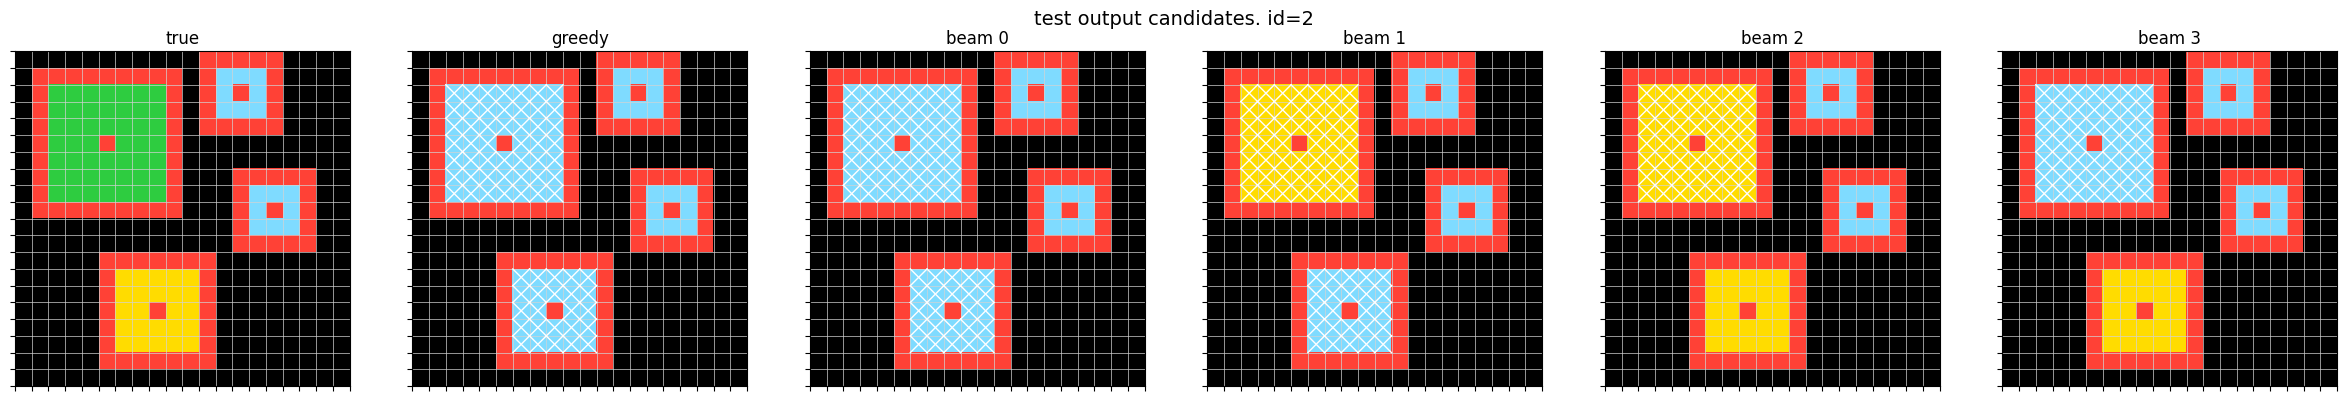

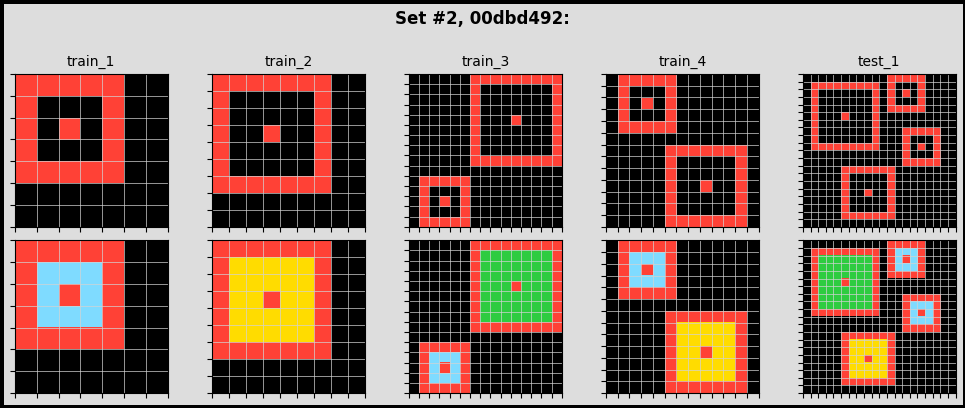

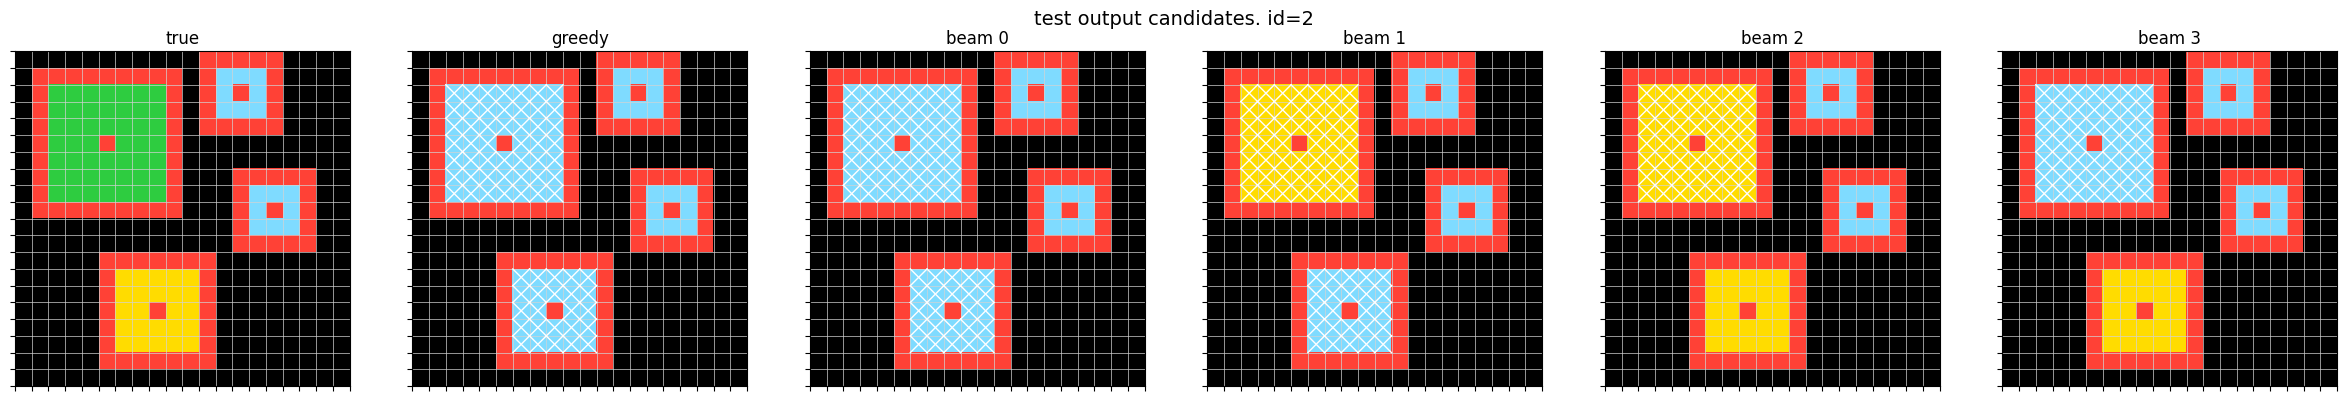

In [10]:
idx = 2

plot_task(val_dataset_simple[idx][1], [val_dataset_simple[idx][1]['test'][0]['output']], idx, val_dataset_simple[idx][0])
plot_generation_results(
    metrics['rearc_lr3em4_bs64']['gen']['greedy']['val'][idx],
    metrics['rearc_lr3em4_bs64']['gen']['beam4']['val'][idx],
    val_dataset[idx]['augmented_sample']['test'][0]['output'],
    tokenizer,
    suptitle='test output candidates. id=%d' % idx,
)

In [11]:
import matplotlib.pyplot as plt
from ipywidgets import IntSlider, Button, HBox, VBox, Output
from IPython.display import display as _display


def _draw_sample(idx,
                val_dataset_simple,
                metrics,
                tokenizer,
                plot_task_image,
                plot_generation_results_image):
    # Close lingering figures ------------------------------------------------
    plt.close('all')

    # --- Task visual --------------------------------------------------------
    plot_task_image(
        val_dataset_simple[idx][1],
        [val_dataset_simple[idx][1]["test"][0]["output"]],
        idx,
        val_dataset_simple[idx][0],
    )

    # --- Generation‑results visual -----------------------------------------
    plot_generation_results_image(
        metrics["rearc_lr3em4_bs64"]["gen"]["greedy"]["val"][idx],
        metrics["rearc_lr3em4_bs64"]["gen"]["beam4"]["val"][idx],
        val_dataset_simple[idx][1]["test"][0]["output"],
        tokenizer,
        suptitle=f"test output candidates – id={idx}",
    )

    # Render both freshly created figs --------------------------------------
    plt.show(block=False)


def launch_viewer(val_dataset_simple,
                  metrics,
                  tokenizer,
                  plot_task_image,
                  plot_generation_results_image,
                  max_idx=None):
    if max_idx is None:
        max_idx = len(val_dataset_simple) - 1

    # ---- widgets -----------------------------------------------------------
    slider = IntSlider(value=0,
                       min=0,
                       max=max_idx,
                       step=1,
                       description="sample idx",
                       continuous_update=False)
    prev_btn = Button(description='◀', tooltip='previous sample')
    next_btn = Button(description='▶', tooltip='next sample')
    out = Output()

    # ---- callbacks ---------------------------------------------------------
    def _update_buttons(idx):
        prev_btn.disabled = idx <= slider.min
        next_btn.disabled = idx >= slider.max

    def _on_value_change(change):
        idx = change["new"]
        _update_buttons(idx)
        with out:
            out.clear_output(wait=True)
            _draw_sample(idx,
                         val_dataset_simple,
                         metrics,
                         tokenizer,
                         plot_task_image,
                         plot_generation_results_image)

    def _go_prev(_):
        if slider.value > slider.min:
            slider.value = slider.value - 1  # triggers _on_value_change

    def _go_next(_):
        if slider.value < slider.max:
            slider.value = slider.value + 1

    # wire up ---------------------------------------------------------------
    slider.observe(_on_value_change, names="value")
    prev_btn.on_click(_go_prev)
    next_btn.on_click(_go_next)

    # initial render --------------------------------------------------------
    _on_value_change({"new": slider.value})

    controls = HBox([prev_btn, slider, next_btn])
    _display(VBox([controls, out]))


def plot_single(idx,
                val_dataset_simple,
                metrics,
                tokenizer,
                plot_task_image,
                plot_generation_results_image):
    """Draw plots for *idx* once (non‑interactive/script use)."""
    _draw_sample(idx,
                 val_dataset_simple,
                 metrics,
                 tokenizer,
                 plot_task_image,
                 plot_generation_results_image)

In [12]:
launch_viewer(val_dataset_simple, metrics, tokenizer, plot_task, plot_generation_results)